# Feature Engineering and EDA

In [1]:
import re
import numpy as np
import pandas as pd
import pickle
import gensim
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

In [275]:
file = open('articles.p', 'rb')      
df = pickle.load(file)
file.close()

In [276]:
drop_indices = df.loc[df['date'] < pd.Timestamp(2019, 3, 15)].index
df.drop(index=drop_indices, inplace=True)

In [277]:
# Drop update articles and investing articles
df = df.loc[df['headline'].map(lambda x: re.search(r'UPDATE', x)).isna()]
df = df.loc[df['headline'].map(lambda x: re.search(r'US STOCKS', x)).isna()]
df = df.loc[df['headline'].map(lambda x: re.search(r'PRESS', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'/education/', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'/politics/', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'/diplomacy/', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'/letters/', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'health-', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'/money/', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'/transport/', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'investing', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'/society/', x)).isna()]
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.drop(columns='url', inplace=True)

In [278]:
df['source'].value_counts()

SCMP               542
Reuters            434
CCTV               182
ABC (Australia)    102
CNN                 81
Name: source, dtype: int64

## Add sentences and words features

In [279]:
def replace_words(text):
    text = re.sub(r'U\.S\.', 'US', text)
    text = re.sub(r'US\s', 'USA ', text)
    text = re.sub(r'U\.K\.', 'UK', text)
    text = re.sub(r'Mr\.', 'MR', text)
    text = re.sub(r'Mrs\.', 'MRS', text)
    text = re.sub(r'Ms\.', 'MS', text)
    text = re.sub(r'\.\.\.', '', text)
    text = re.sub(r'U.S-China', 'US-China', text)
    text = re.sub(r'(\.)(\w)', r'\1 \2', text)
    text = text.replace('Co.', 'Co')
    text = text.replace('\xa0', '')
    text = text.replace('."', '".')
    text = text.replace('immediatelywith', 'immediately with')
    text = text.replace('theOfficeof', 'the Office of')
    text = text.replace('theCommissionerof', 'the Commissioner of')
    text = text.replace('entirelywithin', 'entirely within')
    
    return text

In [280]:
df['body'] = df['body'].map(replace_words)

In [281]:
df['sentences'] = df['body'].map(lambda x: sent_tokenize(x)[:10])

In [13]:
stop_words = stopwords.words('english')

In [14]:
# Function to preprocess each sentence
def preprocess_sent(texts):
    texts_out = []
    for text in texts:
        simple_text = gensim.utils.simple_preprocess(text)
        no_stop = [ word for word in simple_text if word not in stop_words ]
        texts_out.append(no_stop)
    return texts_out

# Funtion to preprocess entire body
def preprocess_body(text):
    simple_text = gensim.utils.simple_preprocess(text)
    text_out = [ word for word in simple_text if word not in stop_words ]
    return text_out

In [282]:
# Preprocess sentences
df['sentence_tokens'] = df['sentences'].map(preprocess_sent)

# Preprocess entire body for training
df['word_tokens'] = df['sentence_tokens'].map(lambda x: [ item for l in x for item in l ])

## Dictionary and bigram/trigram models
- This section heavily borrows from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [283]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [284]:
# For bigram/trigram models
data_words = df['word_tokens']

In [285]:
# Bigram and Trigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [286]:
def make_bigrams_sent(texts):
    return [ bigram_mod[doc] for doc in texts ]

def make_bigrams(text):
    return bigram_mod[text]

def make_trigrams_sent(texts):
    return [ trigram_mod[bigram_mod[doc]] for doc in texts ]

def make_trigrams(text):
    return trigram_mod[bigram_mod[text]]

def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(' '.join(text))
    return [ token.lemma_ for token in doc if token.pos_ in allowed_postags ]

def lemmatize_sent(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent))
        texts_out.append(' '.join([ token.lemma_ for token in doc if token.pos_ in allowed_postags ]))
    return texts_out

In [287]:
# Create bigrams in df['word_tokens']
df['word_tokens'] = df['word_tokens'].map(make_bigrams)

# Create bigrams in df['sentence_tokens']
df['sentence_tokens'] = df['sentence_tokens'].map(make_bigrams_sent)

In [288]:
# Lemmatize df['word_tokens']
df['word_tokens'] = df['word_tokens'].map(lemmatization)

# Lemmatize df['sentence_tokens']
df['sentence_tokens'] = df['sentence_tokens'].map(lemmatize_sent)

In [289]:
# Split into SCMP and not SCMP
df1 = df.loc[df['source'] == 'SCMP'] # SCMP
df2 = df.loc[df['source'] != 'SCMP'] # Not SCMP

In [290]:
# Choose corpus for training
data_lemmatized = df2['word_tokens'] # Not SCMP

In [291]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter extremes from dictionary
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [ id2word.doc2bow(text) for text in texts ]

In [292]:
# Create TF-IDF corpus
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## LDA Models

### Standard LDA

In [148]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       workers=2,
                                       num_topics=4, 
                                       random_state=100,
                                       passes=10,
                                       per_word_topics=True)

In [149]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"police" + 0.023*"protester" + 0.019*"hong_kong" + 0.014*"government" '
  '+ 0.014*"violence" + 0.012*"people" + 0.010*"law" + 0.009*"act" + '
  '0.009*"region" + 0.008*"also"'),
 (1,
  '0.023*"chinese" + 0.011*"also" + 0.010*"support" + 0.010*"hong_kong" + '
  '0.009*"company" + 0.009*"political" + 0.009*"include" + 0.008*"people" + '
  '0.008*"government" + 0.008*"make"'),
 (2,
  '0.025*"protester" + 0.017*"hong_kong" + 0.015*"people" + 0.013*"police" + '
  '0.010*"would" + 0.010*"government" + 0.009*"activist" + 0.009*"city" + '
  '0.008*"call" + 0.008*"student"'),
 (3,
  '0.015*"market" + 0.014*"protester" + 0.014*"fall" + 0.013*"year" + '
  '0.010*"share" + 0.009*"sale" + 0.009*"investor" + 0.009*"hong_kong" + '
  '0.008*"month" + 0.008*"company"')]


In [150]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.397920080811397

Coherence Score:  0.407189144019925


#### Notes:
- Topics:
    - Topic 0: Protests
    - Topic 1: Economic
    - Topic 2: Government

### TF-IDF LDA

In [ ]:
tfidf_lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
                                             id2word=id2word,
                                             workers=4,
                                             num_topics=4,
                                             chunksize=100,
                                             random_state=100,
                                             passes=10,
                                             per_word_topics=False)

In [ ]:
pprint(tfidf_lda_model.print_topics())
doc_tfidf_lda = tfidf_lda_model[corpus]

In [ ]:
print('\nPerplexity: ', tfidf_lda_model.log_perplexity(corpus))

coherence_model_tfidf_lda = CoherenceModel(model=tfidf_lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_tfidf_lda = coherence_model_tfidf_lda.get_coherence()
print('\nCoherence Score: ', coherence_tfidf_lda)

#### Notes:
- Topics:
    - Topic 0: Government
    - Topic 1: Legal Issues
    - Topic 2: Economic
    - Topic 3: Protests

### LDA Mallet

In [38]:
mallet_path = '/Users/waynelam/Documents/DevStuff/mallet-2.0.8/bin/mallet'

In [219]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             random_seed=123,
                                             num_topics=4,
                                             id2word=id2word)

/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [220]:
pprint(ldamallet.show_topics())

[(0,
  '0.081*"protester" + 0.066*"police" + 0.033*"city" + 0.018*"demonstration" + '
  '0.015*"violence" + 0.014*"activist" + 0.014*"rally" + 0.014*"street" + '
  '0.014*"demonstrator" + 0.011*"student"'),
 (1,
  '0.026*"year" + 0.018*"week" + 0.018*"company" + 0.016*"market" + '
  '0.016*"month" + 0.014*"fall" + 0.013*"business" + 0.012*"end" + '
  '0.012*"share" + 0.011*"lead"'),
 (2,
  '0.042*"chinese" + 0.029*"call" + 0.028*"support" + 0.027*"make" + '
  '0.022*"people" + 0.020*"include" + 0.019*"hong_kong" + 0.015*"political" + '
  '0.015*"show" + 0.014*"country"'),
 (3,
  '0.049*"hong_kong" + 0.045*"government" + 0.022*"law" + 0.018*"region" + '
  '0.016*"people" + 0.015*"act" + 0.013*"bill" + 0.013*"mainland" + '
  '0.013*"situation" + 0.012*"official"')]


In [221]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet,
                                           texts=data_lemmatized,
                                           dictionary=id2word,
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.43923238860097163


#### Notes:
- Topics:
    - Topic 0: Violence
    - Topic 1: Economy
    - Topic 2: Politics
    - Topic 3: Government

### Coherence

In [168]:
def compute_coherence_values(start=2, limit=10, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path,
                                                 corpus=corpus,
                                                 id2word=id2word,
                                                 num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=data_lemmatized,
                                        dictionary=id2word,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [216]:
model_list, coherence_values = compute_coherence_values(start=3,
                                                        limit=15,
                                                        step=1)

/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


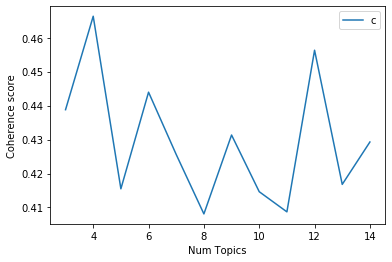

In [217]:
limit = 15
start = 3
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [218]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4388
Num Topics = 4  has Coherence Value of 0.4663
Num Topics = 5  has Coherence Value of 0.4155
Num Topics = 6  has Coherence Value of 0.4439
Num Topics = 7  has Coherence Value of 0.4256
Num Topics = 8  has Coherence Value of 0.4081
Num Topics = 9  has Coherence Value of 0.4313
Num Topics = 10  has Coherence Value of 0.4146
Num Topics = 11  has Coherence Value of 0.4087
Num Topics = 12  has Coherence Value of 0.4563
Num Topics = 13  has Coherence Value of 0.4168
Num Topics = 14  has Coherence Value of 0.4293


In [222]:
mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [263]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet_model, corpus, id2word)
vis.show()

/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.157888  0.331183       1        1  25.785082
3     -0.203218 -0.212129       2        1  25.130169
2     -0.263880  0.102228       3        1  24.672593
1      0.309210 -0.221281       4        1  24.412156, topic_info=    Category        Freq        Term       Total  loglift  logprob
42   Default  919.000000   protester  919.000000  30.0000  30.0000
70   Default  750.000000      police  750.000000  29.0000  29.0000
24   Default  494.000000  government  494.000000  28.0000  28.0000
87   Default  454.000000     chinese  454.000000  27.0000  27.0000
27   Default  743.000000   hong_kong  743.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
16    Topic4  110.379374      demand  140.523975   1.1686  -4.5793
269   Topic4  112.678944        time  154.060506   1.0973  -4.5587
280   Topic4  112.678944      report  159.076687   1.0652  -4.5587
23    Topic4   88.533456        give  128.726257   1.0358  -4.7999
200   Topic4   87.383671      follow  121.742185   1.0785  -4.8129

[285 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
558       3  0.977059          accept
871       2  0.987035  accordance_law
423       3  0.993302         account
536       3  0.998234          accuse
710       2  0.999602             act
...     ...       ...             ...
350       3  0.998612            work
365       3  1.003828           world
568       3  0.994743           write
82        4  1.000733            year
366       1  1.000179           young

[282 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [531]:
pyLDAvis.save_html(vis, 'topic_words.html')

In [330]:
# file = open('mallet.p', 'wb')      
# pickle.dump(mallet_model, file)
# file.close()

In [329]:
# file = open('ldavis.p', 'wb')      
# pickle.dump(vis, file)
# file.close()

## Sentiment

In [52]:
def vader_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)

In [55]:
def polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment[0]

def subjectivity(text):
    analysis = TextBlob(text)
    return analysis.sentiment[1]

In [293]:
# Create column for sentiment analysis
# Sentences for sentiment analysis and sentence_tokens for topic analysis
s = df['sentences']
st = df['sentence_tokens']

combine = []
for i in range(len(s)):
    total = []
    total.append(s[i])
    total.append(st[i])
    combine.append(total)

df['combine'] = combine

In [566]:
def sentiment_doc(combine):
    topic_0 = 0
    topic_1 = 0
    topic_2 = 0
    topic_3 = 0
    count_0 = 0
    count_1 = 0
    count_2 = 0
    count_3 = 0

    reg = combine[0]
    tok = combine[1]
    num_sentences = len(tok)
    for i in range(num_sentences):
        tokens = tok[i].split()
        vec = id2word.doc2bow(tokens)
        topic = topic = sorted(mallet_model[vec], key=lambda tup: tup[1], reverse=True)[0][0]
        sentiment = round(vader_analysis(reg[i])['compound'], 2)
        if topic == 0:
            topic_0 += abs(sentiment)
            count_0 += 1
        elif topic == 1:
            topic_1 += abs(sentiment)
            count_1 += 1
        elif topic == 2:
            topic_2 += abs(sentiment)
            count_2 += 1
        else:
            topic_3 += abs(sentiment)
            count_3 += 1
    return ((round(topic_0, 2), count_0), (round(topic_1, 2), count_1), (round(topic_2, 2), count_2), (round(topic_3, 2), count_3))

In [567]:
df['sentiment'] = df['combine'].map(sentiment_doc)

In [ ]:
# Topic 0: Protests
# Topic 1: Econ
# Topic 2: Poli
# Topic 3: Gov

In [568]:
df['protest'] = df['sentiment'].map(lambda x: x[0][0])
df['econ'] = df['sentiment'].map(lambda x: x[1][0])
df['poli'] = df['sentiment'].map(lambda x: x[2][0])
df['gov'] = df['sentiment'].map(lambda x: x[3][0])
df['protest_mention'] = df['sentiment'].map(lambda x: x[0][1])
df['econ_mention'] = df['sentiment'].map(lambda x: x[1][1])
df['poli_mention'] = df['sentiment'].map(lambda x: x[2][1])
df['gov_mention'] = df['sentiment'].map(lambda x: x[3][1])

In [569]:
df['total_sentences'] = df['protest_mention'] + df['econ_mention'] + df['poli_mention'] + df['gov_mention']

## Data Visualization

In [570]:
df['w_protest'] = df['protest'] * (df['protest_mention'] / df['total_sentences'])
df['w_econ'] = df['econ'] * (df['econ_mention'] / df['total_sentences'])
df['w_gov'] = df['gov'] * (df['gov_mention'] / df['total_sentences'])
df['w_poli'] = df['poli'] * (df['poli_mention'] / df['total_sentences'])

In [540]:
# file = open('dataframe.p', 'wb')      
# pickle.dump(df, file)
# file.close()

In [571]:
df2 = pd.DataFrame(pd.concat([df.iloc[:, 3:4], df.iloc[:, 9:]], axis=1))

In [554]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

In [572]:
# Sentiment analysis of headline
df2['hl_sent'] = df['headline'].map(lambda x: abs(vader_analysis(x)['compound']))

In [543]:
df2.groupby('source')['hl_sent'].mean()

source
ABC (Australia)    0.396051
CCTV               0.351529
CNN                0.366249
Reuters            0.346454
SCMP               0.473217
Name: hl_sent, dtype: float64

In [573]:
df2['protest_ratio'] = df2['protest_mention'] / df2['total_sentences']
df2['econ_ratio'] = df2['econ_mention'] / df2['total_sentences']
df2['poli_ratio'] = df2['poli_mention'] / df2['total_sentences']
df2['gov_ratio'] = df2['gov_mention'] / df2['total_sentences']

In [555]:
df2.head()

,source,protest,econ,poli,gov,protest_mention,econ_mention,poli_mention,gov_mention,total_sentences,w_protest,w_econ,w_gov,w_poli,hl_sent,protest_ratio,econ_ratio,poli_ratio,gov_ratio
0,SCMP,-0.97,0.00,-0.62,-1.14,1,0,1,2,4,-0.242500,0.000000,-0.57,-0.155000,0.2960,0.250000,0.000000,0.250000,0.500000
1,SCMP,-0.58,0.53,-0.77,0.00,4,1,1,0,6,-0.386667,0.088333,0.00,-0.128333,0.7351,0.666667,0.166667,0.166667,0.000000
2,SCMP,-2.13,0.00,-1.57,0.00,4,0,2,0,6,-1.420000,0.000000,0.00,-0.523333,0.6249,0.666667,0.000000,0.333333,0.000000
3,SCMP,0.28,-0.11,0.00,0.00,1,4,0,0,5,0.056000,-0.088000,0.00,0.000000,0.4588,0.200000,0.800000,0.000000,0.000000
4,SCMP,-0.84,0.00,-0.80,-1.19,3,0,1,3,7,-0.360000,0.000000,-0.51,-0.114286,0.8979,0.428571,0.000000,0.142857,0.428571


In [556]:
X = df2.iloc[:, 1:5].values
X = RobustScaler().fit_transform(X)
y = df2['source']

In [557]:
X.shape

(1341, 4)

In [558]:
pca = PCA(n_components=2)

In [559]:
components = pca.fit_transform(X)

In [560]:
comp_df = pd.DataFrame(data = components, columns = ['pc1', 'pc2'])

In [561]:
comp_df['source'] = y

In [562]:
cond1 = (comp_df['source'] == 'CNN')
cond2 = (comp_df['source'] == 'ABC (Australia)')
cond3 = (comp_df['source'] == 'CCTV')
cond4 = (comp_df['source'] == 'Reuters')
cond5 = (comp_df['source'] == 'SCMP')

In [563]:
df2.groupby('source').mean()

,protest,econ,poli,gov,protest_mention,econ_mention,poli_mention,gov_mention,total_sentences,w_protest,w_econ,w_gov,w_poli,hl_sent,protest_ratio,econ_ratio,poli_ratio,gov_ratio
source,,,,,,,,,,,,,,,,,,
ABC (Australia),-0.871765,-0.075098,-0.058235,-0.153039,3.274510,1.049020,1.656863,1.068627,7.049020,-0.624147,0.005725,-0.033412,-0.019549,0.396051,0.578758,0.113725,0.189542,0.117974
CCTV,-0.438846,-0.066648,-0.167198,-0.341209,1.670330,0.945055,1.928571,4.510989,9.054945,-0.207342,-0.016829,-0.229988,-0.075496,0.351529,0.176293,0.103979,0.209319,0.510409
CNN,-0.870370,-0.284074,-0.549506,-0.302593,2.814815,1.765432,3.592593,1.827160,10.000000,-0.480321,-0.146383,-0.115963,-0.284111,0.366249,0.281481,0.176543,0.359259,0.182716
Reuters,-0.835829,-0.213502,-0.057350,-0.135806,3.172811,2.910138,1.808756,1.230415,9.122120,-0.531461,-0.093427,-0.045353,-0.022526,0.346454,0.339544,0.314267,0.200475,0.145713
SCMP,-0.785443,-0.175775,-0.201716,-0.143118,2.488930,1.311808,1.308118,0.983395,6.092251,-0.503856,-0.084295,-0.048244,-0.083536,0.473217,0.408542,0.202822,0.223047,0.165589


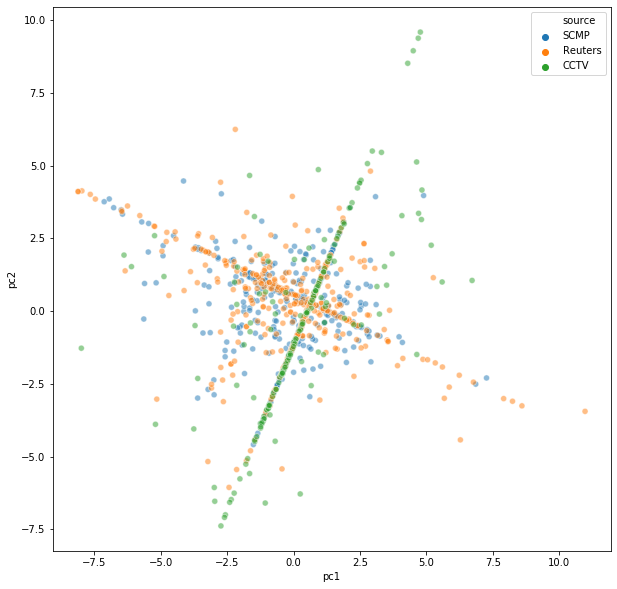

In [564]:
fig = plt.figure(figsize = (10,10))
sns.scatterplot(x='pc1', y='pc2', hue='source', alpha=0.5, data=comp_df.loc[cond4 | cond5 | cond3])
plt.show()

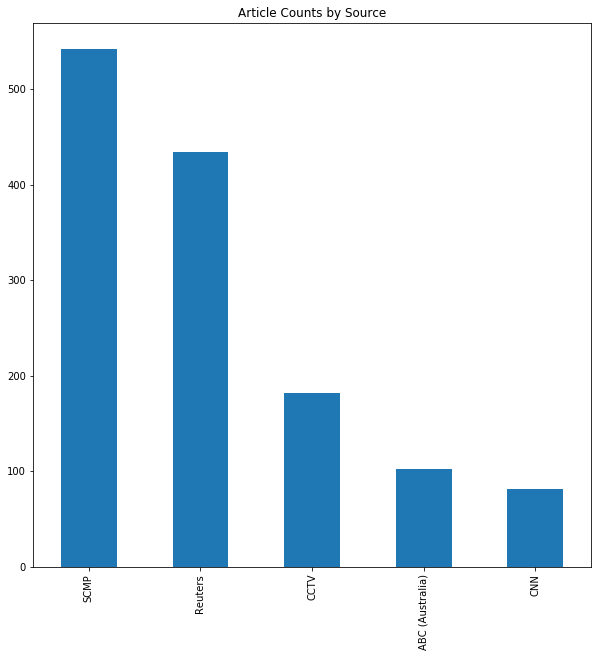

In [473]:
fig = plt.figure(figsize = (10,10))
pd.value_counts(df2['source']).plot.bar()
plt.title('Article Counts by Source')
plt.show()

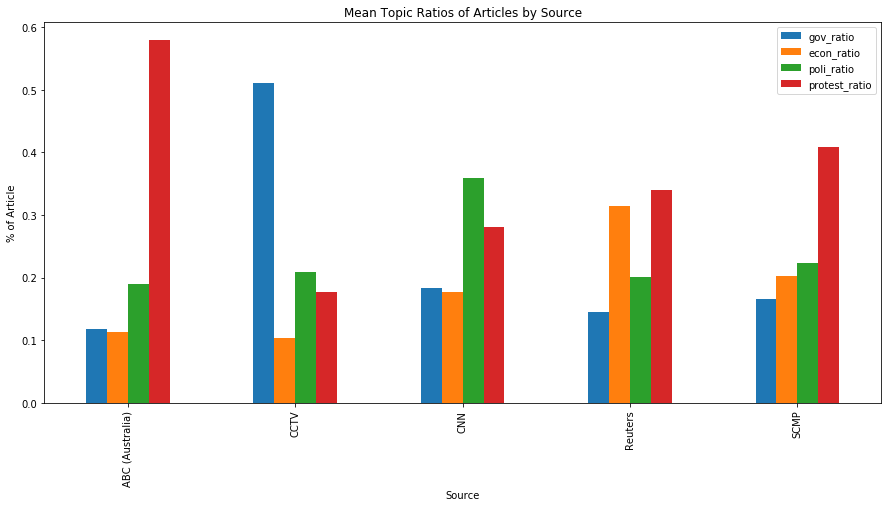

In [521]:
ratios = ['gov_ratio', 'econ_ratio', 'poli_ratio', 'protest_ratio']
fig, ax = plt.subplots(figsize=(15,7))
df2.groupby('source').mean()[ratios].plot(ax=ax, kind='bar')
plt.title('Mean Topic Ratios of Articles by Source')
plt.xlabel('Source')
plt.ylabel('% of Article')
plt.show()

In [484]:
ratios = ['protest_ratio', 'econ_ratio', 'poli_ratio', 'gov_ratio']
df_ratio = df2.loc[:, features]
df_ratio['source'] = df2['source']

In [511]:
df2.groupby('source').mean()

,protest,econ,poli,gov,protest_mention,econ_mention,poli_mention,gov_mention,total_sentences,w_protest,w_econ,w_gov,w_poli,hl_sent,protest_ratio,econ_ratio,poli_ratio,gov_ratio
source,,,,,,,,,,,,,,,,,,
ABC (Australia),1.314902,0.406471,0.659216,0.404804,3.274510,1.049020,1.656863,1.068627,7.049020,0.879206,0.195961,0.123255,0.285333,0.396051,0.578758,0.113725,0.189542,0.117974
CCTV,0.746538,0.385659,0.884780,2.159780,1.670330,0.945055,1.928571,4.510989,9.054945,0.331633,0.136300,1.468200,0.366193,0.351529,0.176293,0.103979,0.209319,0.510409
CNN,1.158025,0.639383,1.345062,0.660370,2.814815,1.765432,3.592593,1.827160,10.000000,0.600741,0.260580,0.228926,0.713765,0.366249,0.281481,0.176543,0.359259,0.182716
Reuters,1.211452,0.963041,0.640161,0.484101,3.172811,2.910138,1.808756,1.230415,9.122120,0.739975,0.612625,0.169493,0.301628,0.346454,0.339544,0.314267,0.200475,0.145713
SCMP,1.032343,0.443413,0.538838,0.413561,2.488930,1.311808,1.308118,0.983395,6.092251,0.638395,0.224564,0.152409,0.224085,0.473217,0.408542,0.202822,0.223047,0.165589


In [499]:
features = ['protest_ratio', 'econ_ratio', 'poli_ratio', 'gov_ratio']
X2 = df2.loc[:, features].values
X2 = MinMaxScaler().fit_transform(X2)
y = df2['source']

In [500]:
comp2 = pca.fit_transform(X2)

In [501]:
comp2_df = pd.DataFrame(data = comp2, columns = ['pc1', 'pc2'])
comp2_df['source'] = y

In [502]:
cond1 = (comp2_df['source'] == 'CNN')
cond2 = (comp2_df['source'] == 'ABC (Australia)')
cond3 = (comp2_df['source'] == 'CCTV')
cond4 = (comp2_df['source'] == 'Reuters')
cond5 = (comp2_df['source'] == 'SCMP')

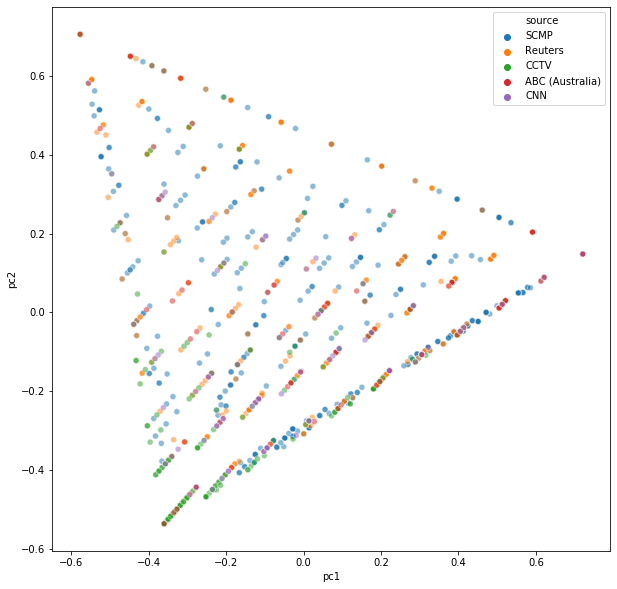

In [504]:
fig = plt.figure(figsize = (10,10))
sns.scatterplot(x='pc1', y='pc2', hue='source', alpha=0.5, data=comp2_df)
plt.show()

In [532]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

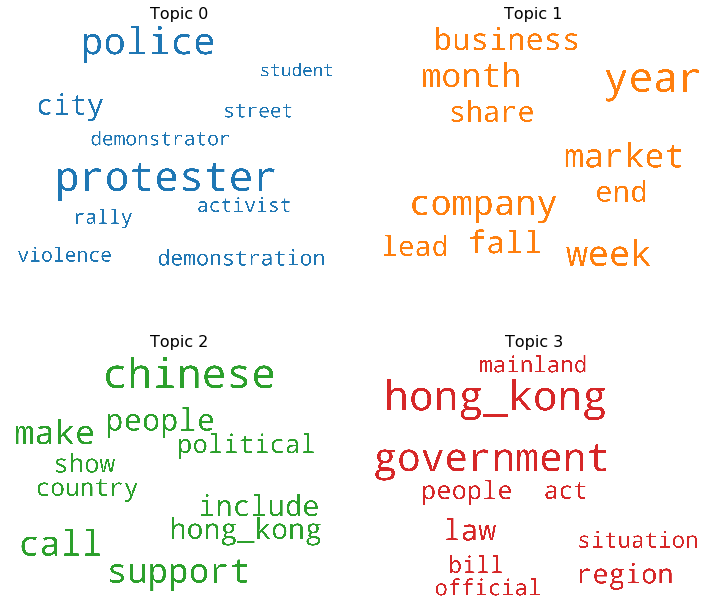

In [533]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = mallet_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [574]:
# file = open('data.p', 'wb')      
# pickle.dump(df2, file)
# file.close()